In [1]:
import numpy as np
import nmrglue
import pandas as pd
def analyze_dataset(all_data):
    # Create a DataFrame with real, imaginary, and time values
    time = np.linspace(0, AQ, len(all_data))
    df = pd.DataFrame({
        "Time": time,
        "Real": all_data.real,
        "Imaginary": all_data.imag
    })
    all_data=nmrglue.proc_base.ps(all_data, p0+90, p1) #Why is there an extra 90 here? Probably from ph31 convention?
    # Apply exponential apodization
    #apodized_data = nmrglue.proc_base.em(all_data, .0004)
    #*********this function can only take real part and not full complex part. Do we want to edit this way?

    ls_and_apodized_data = nmrglue.proc_base.ls(all_data, 63)
    # Plot the results
    
    spectrum = nmrglue.proc_base.fft(ls_and_apodized_data) 
    n = len(all_data.real)
    freq = np.linspace(-SWH / 2+center, SWH / 2+center, n) #I am not sure how to calcualte the bounds of the FT here. But this mehtod lines up with Bruker.
    return (freq, np.real(spectrum), np.imag(spectrum))
    

In [2]:
# Important Acqus Parameters
AQ=1.6# Acquistion time (s)
SWH=2000 #Spectral Width [Hz]
SF=202.4765750 #Spectrometer frequency [Mhz]
SFO1=202.4751988 #Transmitter frequency [Mhz]
SFO2=202.4744409
p0=-35 # MUST change in temporal_average.py for QT
p1=0
center=-(SF-SFO1)*10**6
center2=-(SF-SFO2)*10**6
plot_width=30

#78.32 at 0
#79.50 at -18
#79.74 at -25
#79.83 at -32
#79.82 at -35
#79.59 at -44
#78.66 at -59

In [3]:
file_paths = [
    fr"C:\Users\donny\Desktop\desktop_files\Brown\All_data\Final_Organized_MIT_DATA\2024_12_23-24\NOT_TOMOGRAPHY\ns4_analyze_phase_addition_p04Wdecoupler\{i}"
    for i in range(119, 174+1)  # Adjust the range as needed
]

# Initialize a list to store results
all_results = []

for path in file_paths:
    # Read the data
    all_data = nmrglue.bruker.read(path)[1]

    # Unpack arrays
    array0, array1, array2, _ = all_data

    # Process each array
    rho_0 = analyze_dataset(array0)
    rho_1 = analyze_dataset(array1)
    rho_2 = analyze_dataset(array2)

    # Combine processed arrays: real and imaginary parts
    x = rho_0[0]  # Assuming x is consistent for all files. This gives freq data
    real_data = rho_0[1] + rho_1[1] + rho_2[1]
    imag_data = rho_0[2] + rho_1[2] + rho_2[2]

    # Ensure all arrays have the same length (e.g., 3200)
    assert len(x) == len(real_data) == len(imag_data) == 3200, "Array dimensions mismatch!"

    all_results.append([x, rho_0[1], rho_1[1], rho_2[1], rho_0[2], rho_1[2], rho_2[2], real_data, imag_data])
    #all_results.append([x, real_data, imag_data]) Jiwoo's notation, Shape will be (14, 3, 3200)

# Convert all_results into a NumPy array
results_array = np.array(all_results)  

In [4]:
#now lets group as (14,3,3000)

output = []
for n in range(0, 14):  #
    
    average_result1 = (results_array[0+4*n][1] + results_array[1+4*n][1] + results_array[2+4*n][1] + results_array[3+4*n][1]) / 4
    average_result2 = (results_array[0+4*n][2] + results_array[1+4*n][2] + results_array[2+4*n][2] + results_array[3+4*n][2]) / 4
    average_result3 = (results_array[0+4*n][3] + results_array[1+4*n][3] + results_array[2+4*n][3] + results_array[3+4*n][3]) / 4
    
    output.append([average_result1, average_result2, average_result3])
    #all_results.append([x, real_data, imag_data]) Jiwoo's notation, Shape will be (14, 3, 3200)

# Convert all_results into a NumPy array
ns4_array= np.array(output)  
    

In [5]:
ns4_array.shape
    

(14, 3, 3200)

In [6]:
data = np.mean(ns4_array, axis=1)

In [7]:
data.shape

(14, 3200)

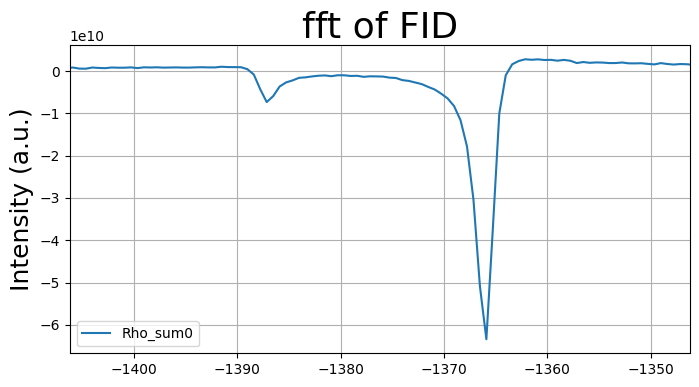

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(x, data[1], label="Rho_sum0")
plt.ylabel("Intensity (a.u.)", fontsize=18)
plt.title("fft of FID", fontsize=26)
plt.legend()
plt.grid(True)
#plt.xlim(SFO1+Plot_width,SFO1-Plot_width)
plt.xlim(center-plot_width,center+plot_width)
#plt.xlim(-1368,-1365)
#plt.gca().invert_xaxis()
plt.show()

In [9]:
from temporal_average import Donnys_custom_ns4_array_function
import nmrglue
data_folder = r"C:\Users\donny\Desktop\desktop_files\Brown\All_data\Final_Organized_MIT_DATA\2024_12_23-24\NOT_TOMOGRAPHY\ns4_analyze_phase_addition_p04Wdecoupler"

freqs, all_spectra_complex = Donnys_custom_ns4_array_function(data_folder, display_avg=True, DISPLAY_I=0)

Computed average spectra for 56 files.


In [10]:
all_spectra_complex.shape

(14, 3200)

In [11]:
freqs


array([-2376.20000001, -2375.57480464, -2374.94960926, ...,
        -377.45039076,  -376.82519538,  -376.20000001])

In [12]:
# DIFFERENT FOR THIS MEASUREMENT!
SPECTRUM_WIDTH = 2000  # Hz


# assert np.array_equal(freqs, freqs_local)

#B_0 = 14.0921  # Tesla
J = 21.6  # Hz
L_FREQ = -J/2
R_FREQ = J/2
PHASE_0=-44

freqs_local = np.linspace(-SPECTRUM_WIDTH / 2, SPECTRUM_WIDTH / 2, all_spectra_complex.shape[1])

In [13]:
all_spectra = np.zeros((all_spectra_complex.shape[0] * 2, all_spectra_complex.shape[1]))

for i in range(all_spectra_complex.shape[0]):
    all_spectra[i * 2, :] = all_spectra_complex[i, :].real
    all_spectra[i * 2 + 1, :] = all_spectra_complex[i, :].imag

all_spectra.shape

(28, 3200)

In [14]:
len(all_spectra_complex[2])

3200

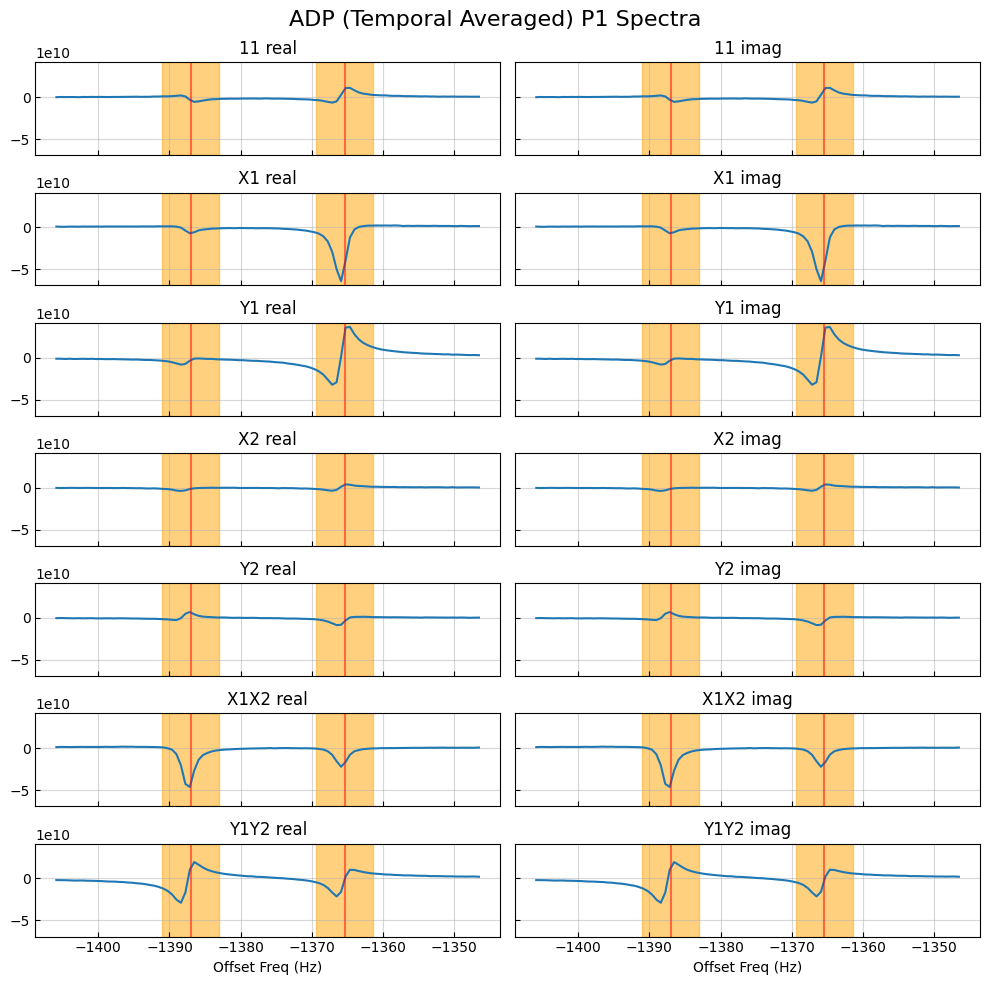

In [15]:
import tomography_helper_functions
import tomography_helper_functions as helper
# from statistics import median
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import nmrglue as ng


# import pulsee.simulation as sim
from plot_dm import plot_complex_density_matrix

import tomography_helper_functions
import tomography_helper_functions as helper
# from tomography.tomography_helper_functions import projection_fortunato, plot_spectra_together
# from tomography.tomography_helper_functions import index_to_element, integrate_simpson, integrate_optimized

# import * is bad practice, but this is the easiest way to do quick theoretical calculations with this many variables.
import operators as op
import global_constants as glob
from coeff_groups_class import CoefficientGroups

from temporal_average import temporal_average

# commented out cuz it causes my computer to not plot anything:
#%matplotlib notebook

plt.rcParams['figure.dpi'] = glob.DPI_DISPLAY


INT_WIDTH = 8  # in Hz. The width to integrate over.
X_LIMS_DISPLAY = [center-30, center+30]


# Making an offset so the red lines visually line up with the peaks
p1_offset =center
p1_freqs = (L_FREQ + p1_offset, R_FREQ + p1_offset)

fig_1, axs_1 = helper.plot_spectra_together(freqs, all_spectra[:all_spectra.shape[0]//2],
                                     glob.SPECTRA_NAMES, X_LIMS_DISPLAY, p1_freqs[0], p1_freqs[1], int_width=INT_WIDTH, share_y=True)
fig_1.suptitle('ADP (Temporal Averaged) P1 Spectra', size=16)
fig_1.tight_layout()
plt.show()

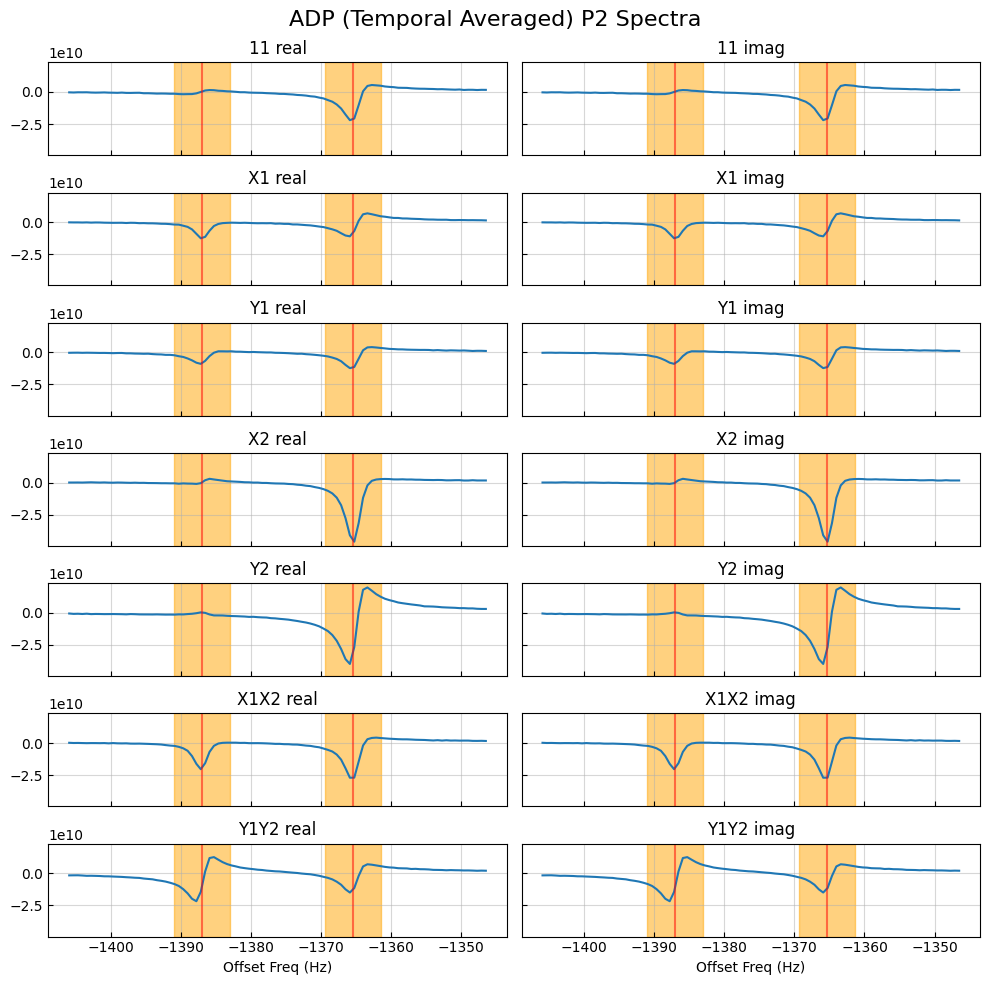

In [16]:
# Making an offset so the red lines visually line up with the peaks
p2_offset = center
p2_freqs = (L_FREQ + p2_offset, R_FREQ + p2_offset)

fig_2, axs_2 = helper.plot_spectra_together(freqs, all_spectra[all_spectra.shape[0] // 2:], glob.SPECTRA_NAMES, X_LIMS_DISPLAY, p2_freqs[0], p2_freqs[1], int_width=INT_WIDTH, share_y=True)
fig_2.suptitle('ADP (Temporal Averaged) P2 Spectra', size=16)
fig_2.tight_layout()
plt.show()


In [17]:
op.check_basis_complete()

Operator basis is complete (15 elements)


In [18]:
coeff_groups_height = CoefficientGroups()

for (i, spectrum) in enumerate(all_spectra):
    # Height of the point closest to each peak's frequency location
    L = spectrum[np.absolute(freqs - L_FREQ).argmin()]
    R = spectrum[np.absolute(freqs - R_FREQ).argmin()]
    coeff_groups_height.add_coefficient(op.product_operators[i][0], L + R, helper.index_to_element(i))
    coeff_groups_height.add_coefficient(op.product_operators[i][1], L - R, helper.index_to_element(i))
    # print(f"Spectrum {thermal_col_names[i]} L+R is: {(L+R):.1e}, L-R is {(L-R):.1e}")

print(f'number of groups is: {len(coeff_groups_height.data)} (<- should be 15)')

number of groups is: 15 (<- should be 15)


findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.


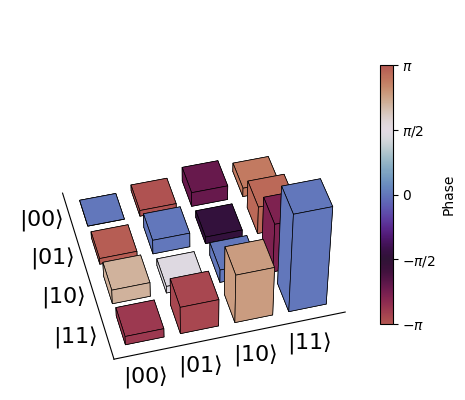

projection of naive integration: (0.7517691050826439+0j)


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.        +0.j         -0.04705896-0.00333782j -0.06880381-0.09052104j
  -0.06554966+0.02350798j]
 [-0.04705896+0.00333782j  0.11328574+0.j          0.00483209-0.05470529j
  -0.21601721+0.03748848j]
 [-0.06880381+0.09052104j  0.00483209+0.05470529j  0.10342653+0.j
  -0.3013779 -0.24970597j]
 [-0.06554966-0.02350798j -0.21601721-0.03748848j -0.3013779 +0.24970597j
   0.78328773+0.j        ]]

In [19]:
rho_naive = helper.integrate_simpson(freqs, all_spectra, p1_freqs, p2_freqs, INT_WIDTH, positive_diag=True)
rho_theory = op.CLEAN_0001
state_name = "large_ns4_0001"
plot_complex_density_matrix(rho_naive)
print(f"projection of naive integration: {helper.projection_fortunato(rho_naive, rho_theory)}")
display(rho_naive)

In [20]:
result_filename = f"result_{state_name}.pickle"
error_filename = f"result_{state_name}_error.pickle"
# result_filename = f"result_{state_name}.pickle"
# error_filename = f"result_{state_name}_error.pickle"

try:
    with open(result_filename, "rb") as result_file:
        best_rho_simpson, best_projection, best_offsets, best_int_width = pickle.load(result_file)
    print("Found previously saved result file!")
        
except FileNotFoundError:
    print("Couldn't find saved result. Integrating and saving the result...")
    best_rho_simpson, best_projection, best_offsets, best_int_width, rho_error = \
        helper.integrate_optimized(freqs, all_spectra, p1_freqs, p2_freqs, rho_theory, return_error=True)
                                   # p1_range=[0], p2_range=[0], width_range=[4])
    with open(result_filename, "wb") as result_file:
        pickle.dump([best_rho_simpson, best_projection, best_offsets, best_int_width], result_file)
    with open(error_filename, "wb") as error_file:
        pickle.dump(rho_error, error_file)


try:
    with open(error_filename, "rb") as error_file:
        rho_error = pickle.load(error_file)
    print("Found previously saved error file")
    
except FileNotFoundError: # in the case where result file exists but error file doesn't.
    print("Couldn't find saved error file. Calculating and saving error")
    rho_error = helper.integrate_simpson(freqs, all_spectra, p1_freqs, p2_freqs, best_int_width,
                                         best_offsets[0], best_offsets[1], return_error=True)
    with open(error_filename, "wb") as error_file:
        pickle.dump(rho_error, error_file)
    

Couldn't find saved result. Integrating and saving the result...
Found previously saved error file


Best parameters: (-1, -1), 1
Best projection: 0.798362617995257


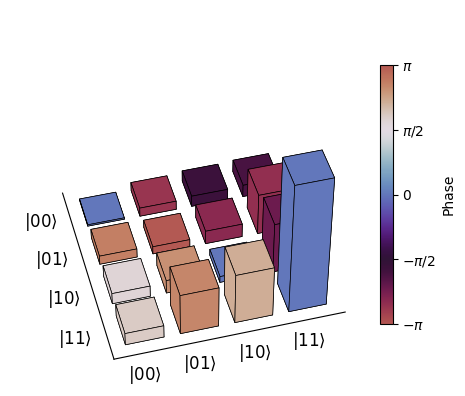

(<Figure size 640x480 with 2 Axes>, <Axes3D: >)

In [21]:
print(f"Best parameters: {best_offsets}, {best_int_width}")
print(f"Best projection: {best_projection}")
plot_complex_density_matrix(best_rho_simpson, label_size=12, label_qubit=True, save_to="")